# Create imputation error plots by SNP & by sample

In [1]:
using Revise
using VCFTools
using MendelImpute
using GeneticVariation
using Random
using StatsBase
using CodecZlib
using ProgressMeter
using JLSO
using BenchmarkTools
using GroupSlices
using LinearAlgebra

using GeneticVariation, Plots
using StatsPlots, FixedPointNumbers, DataFrames, CSV

BLAS.set_num_threads(1)
Plots.scalefontsizes(1.5)

┌ Info: Precompiling MendelImpute [e47305d1-6a61-5370-bc5d-77554d143183]
└ @ Base loading.jl:1278


In [2]:
# impute with max d = 1000
Random.seed!(2020)
tgtfile = "target.chr20.typedOnly.masked.vcf.gz"
reffile = "ref.chr20.excludeTarget.jlso"
outfile = "mendel.chr20.imputed.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile);

# check error rate
X_complete = convert_gt(UInt8, "target.chr20.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")
# rm(outfile, force=true)

Number of threads = 1
Importing reference haplotype data...


Computing optimal haplotypes...100%|████████████████████| Time: 0:00:17


Total windows = 1199, averaging ~ 525 unique haplotypes per window.

Timings: 
    Data import                     = 14.4896 seconds
        import target data             = 3.18545 seconds
        import compressed haplotypes   = 11.3041 seconds
    Computing haplotype pair        = 17.7927 seconds
        BLAS3 mul! to get M and N      = 1.03096 seconds per thread
        haplopair search               = 12.6096 seconds per thread
        initializing missing           = 0.0837177 seconds per thread
        allocating and viewing         = 0.198085 seconds per thread
        index conversion               = 0.00474233 seconds per thread
    Phasing by win-win intersection = 4.78782 seconds
        Window-by-window intersection  = 0.342247 seconds per thread
        Breakpoint search              = 3.31499 seconds per thread
        Recording result               = 0.163908 seconds per thread
    Imputation                     = 6.31643 seconds
        Imputing missing               =

In [3]:
reader = VCF.Reader(openvcf(outfile, "r"))
snpscores = Vector{Float64}(undef, nrecords(outfile))

# loop over SNPs
for (i, record) in enumerate(reader)
    snpscores[i] = parse(Float64, VCF.info(record)[1].second)
end
close(reader)

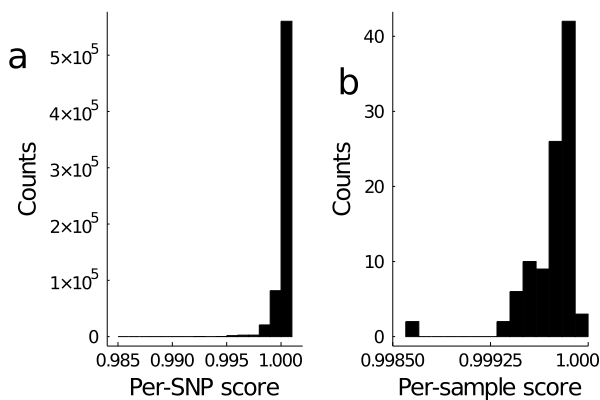

In [6]:
# snperr = histogram(snpscores, label=:none, xlabel="Per-SNP error", grid=false, 
#     xlim=(0, 0.04), color=:black, ylabel="Counts", bins=20)

snperr = histogram(snpscores, label=:none, xlabel="Per-SNP score", grid=false, 
    color=:black, ylabel="Counts", bins=20, xticks = 0.98:0.005:1.0)

quality = CSV.read("mendel.chr20.imputed.sample.error", DataFrame) # import quality score 


# visualize error distribution
sampleerr = histogram(quality[!, :error], label=:none, xlabel="Per-sample score", color=:black,
    grid=false, ylabel="Counts", xlim=(0.9985, 1.0), xticks = range(0.9985, 1.0, length = 3)) 

# combine 2 plots
err_plot = plot(snperr, sampleerr, grid=(2, 1), left_margin = 5Plots.mm)

# add 'A' and 'B' text
fontsize=24
annotate!(err_plot, 0.975, 5*10^5 , text("a", :left, fontsize), subplot=1)
annotate!(err_plot, 0.9981,  34 , text("b", :left, fontsize), subplot=2)

In [5]:
savefig(err_plot, "error.png") # remember to set dpi=300